# GIN+NDS Benchmark: Graph Neural Network Feature Augmentation

This notebook demonstrates a **rigorous benchmark** comparing 8 feature augmentation methods for Graph Isomorphism Networks (GIN) on graph classification tasks.

**Methods evaluated:**
- `vanilla` — baseline GIN with original features
- `degree_only` — degree-based node features
- `nds_tanh_T10` — Nonlinear Diffusion Signatures (NDS) with tanh activation
- `nds_tanh_T10_eigvec` — NDS initialized with Laplacian eigenvectors
- `linear_diff_T10` — Linear diffusion (no nonlinearity)
- `lap_pe_k16` — Laplacian Positional Encoding
- `rwse_k16` — Random Walk Structural Encoding
- `rni_d16` — Random Node Initialization

**Dataset:** MUTAG (molecular graph classification, 2 classes) with K-fold cross-validation.

**Key finding:** Different augmentations have dramatically different effects — NDS-eigvec and LapPE can significantly improve or hurt performance depending on the dataset structure.

In [1]:
import subprocess, sys

def _pip(*a):
    for attempt in range(3):
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])
            return
        except subprocess.CalledProcessError:
            if attempt == 2: raise

# Core packages — pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')
    _pip('torch==2.9.0')

# torch-geometric and loguru — NOT pre-installed on Colab, always install
_pip('torch-geometric')
_pip('loguru')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: /home/adrian/projects/ai-inventor/aii_pipeline/runs/run__20260219_082247/4_gen_paper_repo/notebook_workspaces/exp_id2_it5__opus/.nb_env/bin/python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: /home/adrian/projects/ai-inventor/aii_pipeline/runs/run__20260219_082247/4_gen_paper_repo/notebook_workspaces/exp_id2_it5__opus/.nb_env/bin/python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: /home/adrian/projects/ai-inventor/aii_pipeline/runs/run__20260219_082247/4_gen_paper_repo/notebook_workspaces/exp_id2_it5__opus/.nb_env/bin/python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: /home/adrian/projects/ai-inventor/aii_pipeline/runs/run__20260219_082247/4_gen_paper_repo/notebook_workspaces/exp_id2_it5__opus/.nb_env/bin/python3 -m pip install --upgrade pip


## Imports

In [2]:
import json
import sys
import time
import copy
import warnings
from pathlib import Path

import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.data import Data, Batch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Data Loading

Load the MUTAG graph dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter5_rigorous_gin_nd/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  MUTAG: 38 examples


## Configuration

All tunable parameters are defined here. Adjust these to trade off between speed and accuracy.

In [5]:
# ── Tunable parameters ──
# Original values shown in comments; demo uses reduced values for speed.

SEED = 42
# MAX_EPOCHS = 30        # Original: 30 epochs with early stopping
MAX_EPOCHS = 5           # Demo: reduced for speed
NDS_T = 10               # Diffusion steps (original: 10)
PE_K = 16                # Positional encoding dimension (original: 16)
RNI_DIM = 16             # Random node init dimension (original: 16)
RNI_SEEDS = 1            # Original: 2 random seeds for RNI averaging
# HIDDEN_DIM = 64        # Original: GIN hidden dimension
HIDDEN_DIM = 32          # Demo: reduced for speed
LR = 0.005               # Learning rate (original: 0.005)
DROPOUT = 0.5            # Dropout rate (original: 0.5)
WEIGHT_DECAY = 0.0       # Weight decay (original: 0.0)
# USE_FOLDS = 10         # Original: up to 5-10 depending on dataset
USE_FOLDS = 2            # Demo: 2-fold CV

DS_NAMES = ["MUTAG"]     # Original: ["CSL", "MUTAG", "PROTEINS", "IMDB-BINARY"]

METHODS = [
    "vanilla", "degree_only", "nds_tanh_T10", "nds_tanh_T10_eigvec",
    "linear_diff_T10", "lap_pe_k16", "rwse_k16", "rni_d16",
]

HP = {"lr": LR, "hidden_dim": HIDDEN_DIM, "dropout": DROPOUT, "weight_decay": WEIGHT_DECAY}

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Config: {MAX_EPOCHS} epochs, hidden={HIDDEN_DIM}, {USE_FOLDS} folds, {len(METHODS)} methods")

Config: 5 epochs, hidden=32, 2 folds, 8 methods


## Parse Graphs from JSON

Convert the raw JSON graph representations into PyTorch Geometric `Data` objects with edge indices, node features, and labels.

In [6]:
def parse_graphs(raw_data, ds_names):
    """Parse JSON data into PyTorch Geometric Data objects."""
    datasets = {}
    for ds_entry in raw_data["datasets"]:
        nm = ds_entry["dataset"]
        if nm not in ds_names:
            continue
        graphs = []
        for ex in ds_entry["examples"]:
            gd = json.loads(ex["input"])
            n = gd["num_nodes"]
            edges = gd["edge_list"]
            nf = gd.get("node_features")
            if len(edges) > 0:
                edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            else:
                edge_index = torch.zeros((2, 0), dtype=torch.long)
            if nf is not None and ex.get("metadata_has_node_features", False):
                x = torch.tensor(nf, dtype=torch.float)
            elif nf is not None:
                x = torch.tensor(nf, dtype=torch.float)
            else:
                x = torch.ones((n, 1), dtype=torch.float)
            d = Data(x=x, edge_index=edge_index,
                     y=torch.tensor(int(ex["output"]), dtype=torch.long), num_nodes=n)
            d.fold = ex["metadata_fold"]
            d.ri = ex.get("metadata_row_index", len(graphs))
            graphs.append(d)
        datasets[nm] = graphs
        nc = max(g.y.item() for g in graphs) + 1 if graphs else 0
        print(f"  {nm}: {len(graphs)} graphs, n_classes={nc}, feat_dim={graphs[0].x.shape[1]}")
    return datasets

datasets = parse_graphs(data, DS_NAMES)

  MUTAG: 38 graphs, n_classes=2, feat_dim=7


## Feature Augmentation Methods

Each method computes additional node features from the graph structure:
- **NDS (Nonlinear Diffusion Signatures)**: Iteratively propagates node features through the graph with `tanh` nonlinearity
- **Laplacian PE**: Uses eigenvectors of the graph Laplacian as positional features
- **RWSE**: Diagonal entries of random walk transition matrix powers
- **RNI**: Random Gaussian noise appended to features

In [7]:
def _adj(data):
    n = data.num_nodes
    ei = data.edge_index.numpy()
    if ei.shape[1] == 0:
        return sp.csr_matrix((n, n))
    return sp.coo_matrix((np.ones(ei.shape[1]), (ei[0], ei[1])), shape=(n, n)).tocsr()

def _sym_norm(A):
    deg = np.array(A.sum(axis=1)).flatten()
    d = np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0)
    return sp.diags(d) @ A @ sp.diags(d)

def _safe_eigsh(L, k, n):
    actual_k = min(k + 1, n - 1)
    if actual_k < 2:
        return np.zeros((n, k))
    try:
        _, ev = eigsh(L.tocsc(), k=actual_k, which="SM", maxiter=5000)
        ev = ev[:, 1:k + 1]
    except Exception:
        try:
            _, ev_all = np.linalg.eigh(L.toarray())
            ev = ev_all[:, 1:k + 1]
        except Exception:
            return np.zeros((n, k))
    for j in range(ev.shape[1]):
        idx = np.argmax(np.abs(ev[:, j]))
        if ev[idx, j] < 0:
            ev[:, j] *= -1
    if ev.shape[1] < k:
        ev = np.pad(ev, ((0, 0), (0, k - ev.shape[1])))
    return ev

def compute_degree_feat(data):
    deg = np.array(_adj(data).sum(axis=1)).flatten()
    return torch.tensor(deg.reshape(-1, 1), dtype=torch.float)

def compute_nds(data, T=10, ds_name=""):
    A = _adj(data)
    An = _sym_norm(A)
    deg = np.array(A.sum(axis=1)).flatten()
    if ds_name == "CSL":
        A2 = A @ A
        A3 = A2 @ A
        tri = np.array(A3.diagonal()).flatten() / 2.0
        p2 = np.array(A2.diagonal()).flatten().astype(np.float64)
        x0 = np.column_stack([deg, tri, p2])
    else:
        A2 = A @ A
        A3 = A2 @ A
        tri_count = np.array(A3.diagonal()).flatten() / 2.0
        denom = deg * (deg - 1.0)
        cc = np.where(denom > 0, 2.0 * tri_count / denom, 0.0)
        x0 = np.column_stack([deg, cc])
    traj = [x0.copy()]
    xc = x0.copy()
    for _ in range(T):
        xc = np.tanh(An @ xc)
        traj.append(xc.copy())
    return torch.tensor(np.concatenate(traj, axis=1), dtype=torch.float)

def compute_nds_eigvec(data, T=10, k=8, use_tanh=True):
    n = data.num_nodes
    An = _sym_norm(_adj(data))
    L = sp.eye(n) - An
    x0 = _safe_eigsh(L, k=k, n=n)
    traj = [x0.copy()]
    xc = x0.copy()
    for _ in range(T):
        propagated = An @ xc
        xc = np.tanh(propagated) if use_tanh else propagated
        traj.append(xc.copy())
    return torch.tensor(np.concatenate(traj, axis=1), dtype=torch.float)

def compute_lappe(data, K=16):
    n = data.num_nodes
    L = sp.eye(n) - _sym_norm(_adj(data))
    return torch.tensor(_safe_eigsh(L, k=K, n=n), dtype=torch.float)

def compute_rwse(data, K=16):
    n = data.num_nodes
    A = _adj(data)
    deg = np.array(A.sum(axis=1)).flatten()
    Arw = sp.diags(np.where(deg > 0, 1.0 / deg, 0.0)) @ A
    r = np.zeros((n, K))
    pw = sp.eye(n, format="csr")
    for k_step in range(K):
        pw = pw @ Arw
        r[:, k_step] = pw.diagonal()
    return torch.tensor(r, dtype=torch.float)

def compute_rni(data, dim=16, seed=0):
    return torch.tensor(np.random.RandomState(seed).randn(data.num_nodes, dim).astype(np.float32))

def clone_with_x(data, new_x):
    d = Data(x=new_x, edge_index=data.edge_index.clone(),
             y=data.y.clone(), num_nodes=data.num_nodes)
    d.fold = data.fold
    d.ri = data.ri
    return d

def cat_f(orig, extra):
    return torch.cat([orig, extra], dim=1)

print("Feature augmentation functions defined.")

Feature augmentation functions defined.


## Precompute Features

Apply all 8 augmentation methods to every graph and cache the results for efficient training.

In [8]:
def precompute_features(graphs, methods, ds_name):
    """Precompute augmented features for all methods."""
    cache = {}
    for method in methods:
        if method == "rni_d16":
            for s in range(RNI_SEEDS):
                key = f"rni_d16_seed{s}"
                cache[key] = [clone_with_x(g, cat_f(g.x, compute_rni(g, RNI_DIM, SEED + s * 100)))
                              for g in graphs]
            continue
        aug = []
        for g in graphs:
            if method == "vanilla":
                aug.append(clone_with_x(g, g.x.clone()))
            elif method == "degree_only":
                aug.append(clone_with_x(g, cat_f(g.x, compute_degree_feat(g))))
            elif method == "nds_tanh_T10":
                aug.append(clone_with_x(g, cat_f(g.x, compute_nds(g, NDS_T, ds_name))))
            elif method == "nds_tanh_T10_eigvec":
                aug.append(clone_with_x(g, cat_f(g.x, compute_nds_eigvec(g, NDS_T, 8, True))))
            elif method == "linear_diff_T10":
                aug.append(clone_with_x(g, cat_f(g.x, compute_nds_eigvec(g, NDS_T, 8, False))))
            elif method == "lap_pe_k16":
                aug.append(clone_with_x(g, cat_f(g.x, compute_lappe(g, PE_K))))
            elif method == "rwse_k16":
                aug.append(clone_with_x(g, cat_f(g.x, compute_rwse(g, PE_K))))
        cache[method] = aug
    return cache

# Precompute for all datasets
all_caches = {}
for ds_name in DS_NAMES:
    if ds_name not in datasets:
        continue
    graphs = datasets[ds_name]
    t0 = time.time()
    all_caches[ds_name] = precompute_features(graphs, METHODS, ds_name)
    print(f"  {ds_name}: precomputed in {time.time()-t0:.1f}s")
    for m in METHODS:
        key = "rni_d16_seed0" if m == "rni_d16" else m
        if key in all_caches[ds_name]:
            print(f"    {m}: feat_dim={all_caches[ds_name][key][0].x.shape[1]}")

  MUTAG: precomputed in 0.8s
    vanilla: feat_dim=7
    degree_only: feat_dim=8
    nds_tanh_T10: feat_dim=29
    nds_tanh_T10_eigvec: feat_dim=95
    linear_diff_T10: feat_dim=95
    lap_pe_k16: feat_dim=23
    rwse_k16: feat_dim=23
    rni_d16: feat_dim=23


## GIN Model

3-layer Graph Isomorphism Network with BatchNorm, dropout, and global sum pooling — the standard architecture for graph classification benchmarks.

In [9]:
class GIN(nn.Module):
    def __init__(self, in_dim, hid, out_dim, nl=3, drop=0.5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.drop = drop
        for i in range(nl):
            d = in_dim if i == 0 else hid
            mlp = nn.Sequential(nn.Linear(d, hid), nn.BatchNorm1d(hid), nn.ReLU(), nn.Linear(hid, hid))
            self.convs.append(GINConv(mlp, train_eps=True))
            self.bns.append(nn.BatchNorm1d(hid))
        self.clf = nn.Sequential(nn.Linear(hid, hid), nn.ReLU(), nn.Dropout(drop), nn.Linear(hid, out_dim))

    def forward(self, x, ei, batch):
        for c, b in zip(self.convs, self.bns):
            x = F.dropout(F.relu(b(c(x, ei))), p=self.drop, training=self.training)
        return self.clf(global_add_pool(x, batch))

print("GIN model defined.")

GIN model defined.


## Training Loop

Train GIN on one fold using full-batch training with early stopping on train loss. Returns test accuracy and predictions for the held-out fold.

In [10]:
def train_one_fold(graphs, fold_id, num_classes, hp, max_epochs=50):
    """Train GIN on one fold using full-batch. Track best by train loss."""
    t0 = time.time()
    torch.manual_seed(SEED + fold_id)

    test_g = [g for g in graphs if g.fold == fold_id]
    train_g = [g for g in graphs if g.fold != fold_id]
    if len(test_g) == 0 or len(train_g) < 2:
        return {"val_acc": 0.0, "test_acc": 0.0, "preds": {}, "time": 0.0}

    in_dim = graphs[0].x.shape[1]
    train_batch = Batch.from_data_list(train_g)
    test_batch = Batch.from_data_list(test_g)

    model = GIN(in_dim, hp["hidden_dim"], num_classes, nl=3, drop=hp["dropout"])
    opt = torch.optim.Adam(model.parameters(), lr=hp["lr"], weight_decay=hp["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=10, factor=0.5)

    best_loss = float("inf")
    best_state = None
    patience_count = 0
    patience_limit = 15

    for ep in range(max_epochs):
        model.train()
        opt.zero_grad()
        out = model(train_batch.x, train_batch.edge_index, train_batch.batch)
        loss = F.cross_entropy(out, train_batch.y)
        loss.backward()
        opt.step()

        cur_loss = loss.item()
        scheduler.step(cur_loss)

        if cur_loss < best_loss - 1e-4:
            best_loss = cur_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_count = 0
        else:
            patience_count += 1
            if patience_count >= patience_limit:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()

    with torch.no_grad():
        test_pred = model(test_batch.x, test_batch.edge_index, test_batch.batch).argmax(dim=1)
        test_acc = (test_pred == test_batch.y).float().mean().item()
        train_pred = model(train_batch.x, train_batch.edge_index, train_batch.batch).argmax(dim=1)
        train_acc = (train_pred == train_batch.y).float().mean().item()

    preds = {}
    pred_np = test_pred.cpu().numpy()
    for i, g in enumerate(test_g):
        preds[g.ri] = str(int(pred_np[i]))

    return {"val_acc": train_acc, "test_acc": test_acc, "preds": preds, "time": time.time() - t0}

print("Training function defined.")

Training function defined.


## Run Benchmark

Execute K-fold cross-validation for all 8 methods on the MUTAG dataset. Each method trains a separate GIN model with its augmented features.

In [11]:
all_results = {}
start_time = time.time()

for ds_name in DS_NAMES:
    if ds_name not in datasets:
        continue
    graphs = datasets[ds_name]
    num_classes = max(g.y.item() for g in graphs) + 1
    available_folds = sorted(set(g.fold for g in graphs))
    use_folds = min(USE_FOLDS, len(available_folds))
    fold_ids = available_folds[:use_folds]

    cache = all_caches[ds_name]
    all_results[ds_name] = {}

    print(f"\n{'='*60}")
    print(f"Dataset: {ds_name} — {len(graphs)} graphs, {num_classes} classes, {use_folds} folds")
    print(f"{'='*60}")

    for method in METHODS:
        t_method = time.time()

        if method == "rni_d16":
            all_fold_accs = []
            for s in range(RNI_SEEDS):
                key = f"rni_d16_seed{s}"
                aug = cache[key]
                for fid in fold_ids:
                    res = train_one_fold(aug, fid, num_classes, HP, MAX_EPOCHS)
                    all_fold_accs.append(res["test_acc"])
            mean_acc = np.mean(all_fold_accs) * 100 if all_fold_accs else 0.0
            std_acc = np.std(all_fold_accs) * 100 if all_fold_accs else 0.0
        else:
            aug = cache[method]
            fold_accs = []
            for fid in fold_ids:
                res = train_one_fold(aug, fid, num_classes, HP, MAX_EPOCHS)
                fold_accs.append(res["test_acc"])
            mean_acc = np.mean(fold_accs) * 100 if fold_accs else 0.0
            std_acc = np.std(fold_accs) * 100 if fold_accs else 0.0

        elapsed = time.time() - t_method
        all_results[ds_name][method] = {
            "mean_acc": mean_acc, "std_acc": std_acc,
            "result_str": f"{mean_acc:.1f}±{std_acc:.1f}",
        }
        print(f"  {method:25s}: {mean_acc:.1f}±{std_acc:.1f}% ({elapsed:.1f}s)")

total_time = time.time() - start_time
print(f"\nTotal benchmark time: {total_time:.0f}s ({total_time/60:.1f}min)")


Dataset: MUTAG — 38 graphs, 2 classes, 2 folds


  vanilla                  : 68.4±0.0% (24.9s)


  degree_only              : 68.4±0.0% (20.3s)


  nds_tanh_T10             : 68.4±0.0% (20.9s)


  nds_tanh_T10_eigvec      : 76.3±7.9% (30.1s)


  linear_diff_T10          : 68.4±0.0% (26.9s)


  lap_pe_k16               : 68.4±0.0% (35.4s)


  rwse_k16                 : 68.4±0.0% (35.2s)


  rni_d16                  : 68.4±0.0% (36.4s)

Total benchmark time: 230s (3.8min)


## Results Visualization

Compare all 8 augmentation methods side-by-side. The bar chart shows mean accuracy ± standard deviation across folds.

RESULTS SUMMARY

MUTAG:
  Method                    |     Accuracy
  --------------------------+-------------
  vanilla                   |     68.4±0.0
  degree_only               |     68.4±0.0
  nds_tanh_T10              |     68.4±0.0
  nds_tanh_T10_eigvec       |     76.3±7.9
  linear_diff_T10           |     68.4±0.0
  lap_pe_k16                |     68.4±0.0
  rwse_k16                  |     68.4±0.0
  rni_d16                   |     68.4±0.0


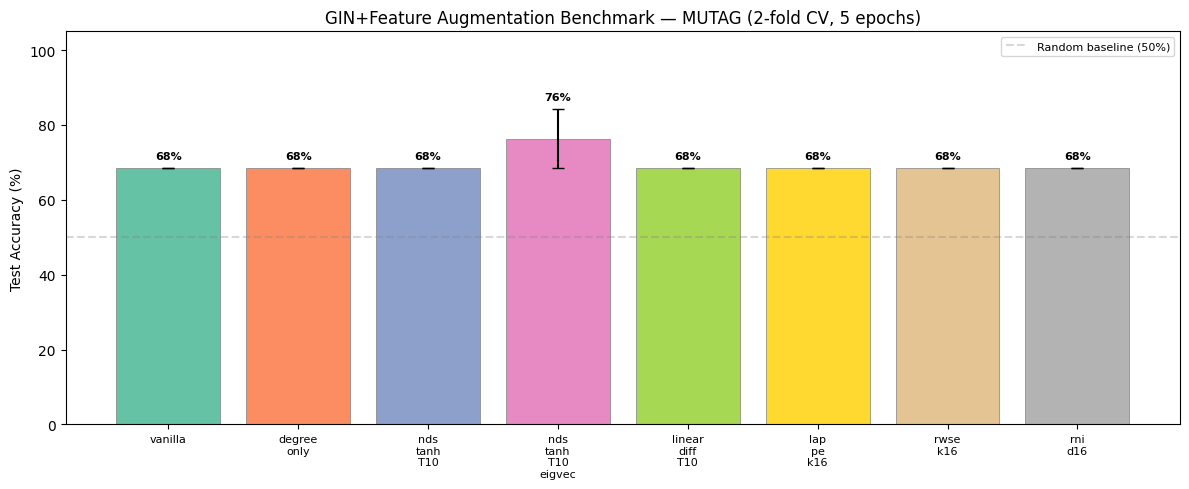


Done!


In [12]:
# ── Results Table ──
print("=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
for ds_name in DS_NAMES:
    if ds_name not in all_results:
        continue
    print(f"\n{ds_name}:")
    print(f"  {'Method':<25s} | {'Accuracy':>12s}")
    print(f"  {'-'*25}-+-{'-'*12}")
    for m in METHODS:
        if m in all_results[ds_name]:
            print(f"  {m:<25s} | {all_results[ds_name][m]['result_str']:>12s}")

# ── Bar Chart ──
fig, ax = plt.subplots(figsize=(12, 5))

for ds_name in DS_NAMES:
    if ds_name not in all_results:
        continue
    methods_present = [m for m in METHODS if m in all_results[ds_name]]
    means = [all_results[ds_name][m]["mean_acc"] for m in methods_present]
    stds = [all_results[ds_name][m]["std_acc"] for m in methods_present]

    x = np.arange(len(methods_present))
    colors = plt.cm.Set2(np.linspace(0, 1, len(methods_present)))
    bars = ax.bar(x, means, yerr=stds, capsize=4, color=colors, edgecolor="gray", linewidth=0.5)

    ax.set_xticks(x)
    ax.set_xticklabels([m.replace("_", "\n") for m in methods_present], fontsize=8, ha="center")
    ax.set_ylabel("Test Accuracy (%)")
    ax.set_title(f"GIN+Feature Augmentation Benchmark — {ds_name} ({USE_FOLDS}-fold CV, {MAX_EPOCHS} epochs)")
    ax.set_ylim(0, 105)
    ax.axhline(y=50, color="gray", linestyle="--", alpha=0.3, label="Random baseline (50%)")
    ax.legend(fontsize=8)

    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + std + 2,
                f"{mean:.0f}%", ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.tight_layout()
plt.show()
print("\nDone!")